In [8]:
import pandas as pd
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.optim as optim
from sklearn.metrics import mean_squared_error


In [9]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(1)

In [10]:
df = pd.read_csv("data_final.csv")
df = df.sort_values("observation_date")
df = df.reset_index(drop=True)

macro_features = [
    'FEDFUNDS',
    'UNRATE',
    'GS10',
    'DTWEXBGS',
    'DCOILWTICO',
    'GOLD',
    'MOVE',
    'VIXCLS'
]

technical_features = [
    'SMA_10',
    'SMA_50',
    'EMA_10',
    'EMA_50',
    'ROC_10',
    'RSI_14',
    'BB_upper',
    'BB_lower',
    'Volatility_20'
]


df['log_return'] = np.log(df['SP500'] / df['SP500'].shift(1))
df = df.dropna().reset_index(drop=True)

target = 'log_return'

X_macro = df[macro_features].values
y_macro = df[[target]].values
X_technical = df[technical_features].values
y_technical = df[[target]].values


Epoch [10/200], Train Loss: 0.052541
Epoch [20/200], Train Loss: 0.057911
Epoch [30/200], Train Loss: 0.043174
Epoch [40/200], Train Loss: 0.037916
Epoch [50/200], Train Loss: 0.034611
Epoch [60/200], Train Loss: 0.031071
Epoch [70/200], Train Loss: 0.028555
Epoch [80/200], Train Loss: 0.026550
Epoch [90/200], Train Loss: 0.024881
Epoch [100/200], Train Loss: 0.023507
Epoch [110/200], Train Loss: 0.022369
Epoch [120/200], Train Loss: 0.021411
Epoch [130/200], Train Loss: 0.020593
Epoch [140/200], Train Loss: 0.019885
Epoch [150/200], Train Loss: 0.019263
Epoch [160/200], Train Loss: 0.018712
Epoch [170/200], Train Loss: 0.018217
Epoch [180/200], Train Loss: 0.017769
Epoch [190/200], Train Loss: 0.017360
Epoch [200/200], Train Loss: 0.016985

Test Loss: 0.061365


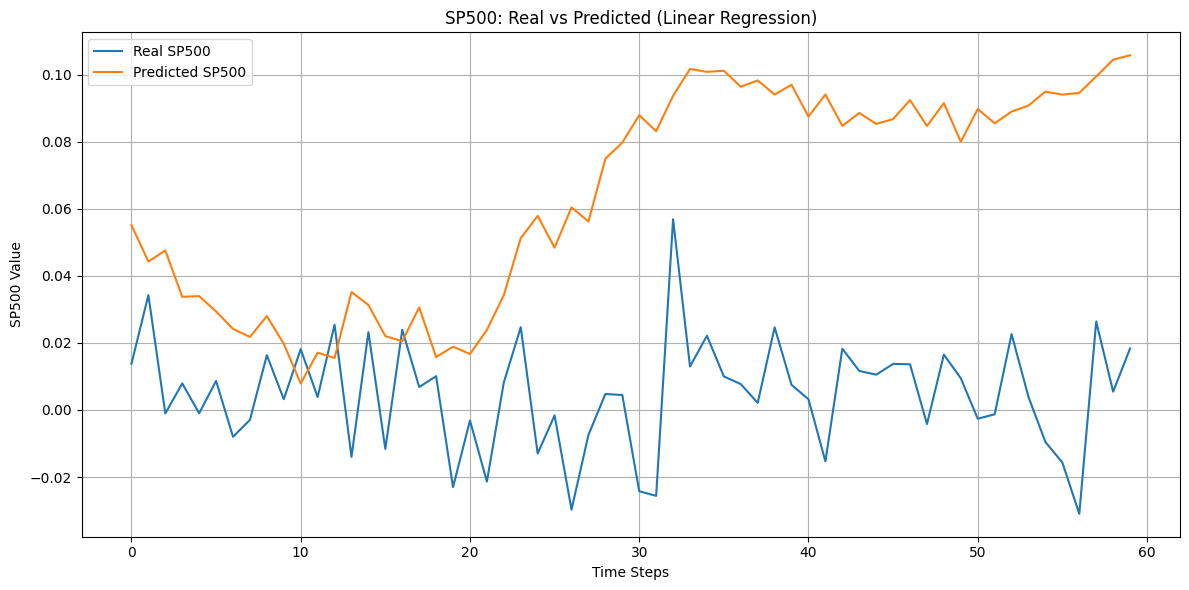

Mean Squared Error: 2.644068
Directional Accuracy (Linear Regression): 33.90%


In [ ]:
seq_length = 20
X_macro = df[macro_features].values
y_macro = df[['log_return']].values

def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

X_macro_seq_raw, y_macro_seq_raw = create_sequences(X_macro, y_macro, seq_length)

def train_test_split(X, y, train_ratio=0.85):
    total = X.shape[0]
    train_end = int(total * train_ratio)
    return X[:train_end], y[:train_end], X[train_end:], y[train_end:]

X_train_raw, y_train_raw, X_test_raw, y_test_raw = train_test_split(X_macro_seq_raw, y_macro_seq_raw)

macro_scaler = MinMaxScaler()
X_train_flat = X_train_raw.reshape(-1, X_train_raw.shape[-1])
X_train_scaled = macro_scaler.fit_transform(X_train_flat).reshape(X_train_raw.shape)
X_test_scaled = macro_scaler.transform(X_test_raw.reshape(-1, X_test_raw.shape[-1])).reshape(X_test_raw.shape)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train_raw)
y_test_scaled = y_scaler.transform(y_test_raw)

X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test = torch.tensor(y_test_scaled, dtype=torch.float32)

class LinearRegressionModel(nn.Module):
    def __init__(self, input_size, seq_length):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size * seq_length, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)  
        return self.linear(x)

input_size = X_train.shape[2]  
seq_length = X_train.shape[1]  
model = LinearRegressionModel(input_size, seq_length)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

num_epochs = 200
train_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.6f}")

model.eval()
with torch.no_grad():
    predictions = model(X_test)
    test_loss = criterion(predictions, y_test)
    print(f"\nTest Loss: {test_loss.item():.6f}")

y_test_np = y_test.cpu().numpy()
pred_np = predictions.cpu().numpy()

sp500_real = y_scaler.inverse_transform(y_test_np)
sp500_pred = y_scaler.inverse_transform(pred_np)

plt.figure(figsize=(12, 6))
plt.plot(sp500_real, label='Real SP500')
plt.plot(sp500_pred, label='Predicted SP500')
plt.title('SP500: Real vs Predicted (Linear Regression)')
plt.xlabel('Time Steps')
plt.ylabel('SP500 Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

real = sp500_real.flatten()
pred = sp500_pred.flatten()
real_diff = np.sign(np.diff(real))
pred_diff = np.sign(np.diff(pred))
directional_accuracy = np.mean(real_diff == pred_diff)
mse = mean_squared_error(real, pred)
print(f"Mean Squared Error: {mse:.6f}")
print(f"Directional Accuracy (Linear Regression): {directional_accuracy:.2%}")

Epoch [10/200], Train Loss: 0.059003
Epoch [20/200], Train Loss: 0.047938
Epoch [30/200], Train Loss: 0.034108
Epoch [40/200], Train Loss: 0.020700
Epoch [50/200], Train Loss: 0.018538
Epoch [60/200], Train Loss: 0.017663
Epoch [70/200], Train Loss: 0.016935
Epoch [80/200], Train Loss: 0.016448
Epoch [90/200], Train Loss: 0.016048
Epoch [100/200], Train Loss: 0.015680
Epoch [110/200], Train Loss: 0.015338
Epoch [120/200], Train Loss: 0.015021
Epoch [130/200], Train Loss: 0.014726
Epoch [140/200], Train Loss: 0.014451
Epoch [150/200], Train Loss: 0.014196
Epoch [160/200], Train Loss: 0.013959
Epoch [170/200], Train Loss: 0.013738
Epoch [180/200], Train Loss: 0.013533
Epoch [190/200], Train Loss: 0.013342
Epoch [200/200], Train Loss: 0.013162

Test Loss: 0.007027


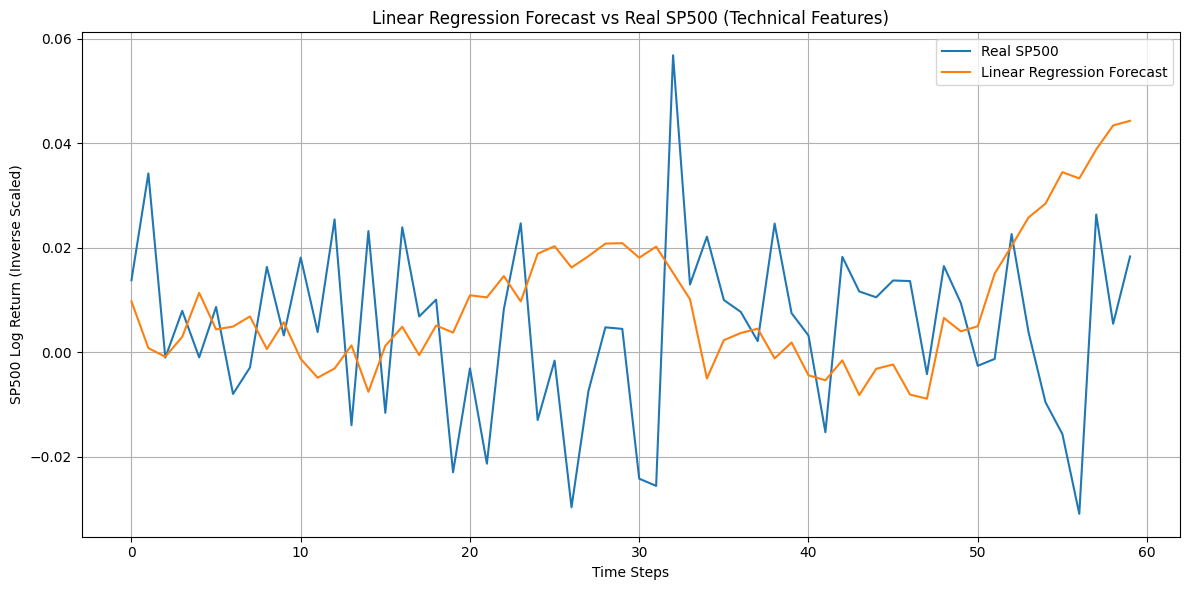

Mean Squared Error: 1.830508
Directional Accuracy (Technical Features): 54.24%


In [ ]:
X_technical = df[technical_features].values
y_macro = df[['log_return']].values
seq_length = 20

def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

X_tech_seq_raw, y_tech_seq_raw = create_sequences(X_technical, y_macro, seq_length)

def train_test_split(X, y, train_ratio=0.85):
    total = X.shape[0]
    train_end = int(total * train_ratio)
    return X[:train_end], y[:train_end], X[train_end:], y[train_end:]

X_train_raw, y_train_raw, X_test_raw, y_test_raw = train_test_split(X_tech_seq_raw, y_tech_seq_raw)

tech_scaler = MinMaxScaler()
X_train_flat = X_train_raw.reshape(-1, X_train_raw.shape[-1])
X_train_scaled = tech_scaler.fit_transform(X_train_flat).reshape(X_train_raw.shape)
X_test_scaled = tech_scaler.transform(X_test_raw.reshape(-1, X_test_raw.shape[-1])).reshape(X_test_raw.shape)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train_raw)
y_test_scaled = y_scaler.transform(y_test_raw)

X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test = torch.tensor(y_test_scaled, dtype=torch.float32)

class LinearRegressionModel(nn.Module):
    def __init__(self, input_size, seq_length):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size * seq_length, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)  
        return self.linear(x)

input_size = X_train.shape[2]
seq_length = X_train.shape[1]
model = LinearRegressionModel(input_size, seq_length)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

num_epochs = 200
train_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.6f}")

model.eval()
with torch.no_grad():
    predictions = model(X_test)
    test_loss = criterion(predictions, y_test)
    print(f"\nTest Loss: {test_loss.item():.6f}")

pred_inv = y_scaler.inverse_transform(predictions.numpy())
y_test_inv = y_scaler.inverse_transform(y_test.numpy())

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="Real SP500")
plt.plot(pred_inv, label="Linear Regression Forecast")
plt.title("Linear Regression Forecast vs Real SP500 (Technical Features)")
plt.xlabel("Time Steps")
plt.ylabel("SP500 Log Return (Inverse Scaled)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

real = y_test_inv.flatten()
pred = pred_inv.flatten()
real_diff = np.sign(np.diff(real))
pred_diff = np.sign(np.diff(pred))
directional_accuracy = np.mean(real_diff == pred_diff)
mse = mean_squared_error(real, pred)
print(f"Mean Squared Error: {mse:.6f}")
print(f"Directional Accuracy (Technical Features): {directional_accuracy:.2%}")



Epoch [10/200], Train Loss: 0.139482
Epoch [20/200], Train Loss: 0.043931
Epoch [30/200], Train Loss: 0.024219
Epoch [40/200], Train Loss: 0.019535
Epoch [50/200], Train Loss: 0.017045
Epoch [60/200], Train Loss: 0.015274
Epoch [70/200], Train Loss: 0.014078
Epoch [80/200], Train Loss: 0.013422
Epoch [90/200], Train Loss: 0.013063
Epoch [100/200], Train Loss: 0.012808
Epoch [110/200], Train Loss: 0.012602
Epoch [120/200], Train Loss: 0.012430
Epoch [130/200], Train Loss: 0.012282
Epoch [140/200], Train Loss: 0.012148
Epoch [150/200], Train Loss: 0.012025
Epoch [160/200], Train Loss: 0.011909
Epoch [170/200], Train Loss: 0.011799
Epoch [180/200], Train Loss: 0.011694
Epoch [190/200], Train Loss: 0.011591
Epoch [200/200], Train Loss: 0.011491

Test Loss: 0.009116
Mean Squared Error: 1.898305
Directional Accuracy: 52.54%


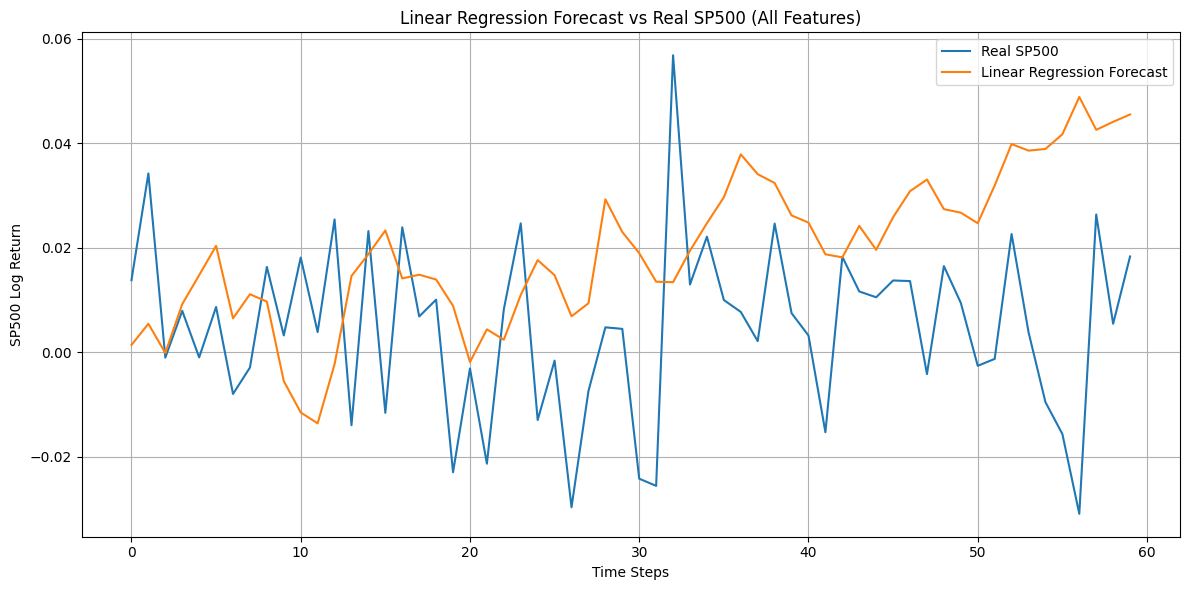

In [ ]:
features = macro_features + technical_features
X_all_raw = df[features].values
y_raw = df[['log_return']].values
seq_length = 20

def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

X_seq_raw, y_seq_raw = create_sequences(X_all_raw, y_raw, seq_length)

def train_test_split(X, y, train_ratio=0.85):
    total = X.shape[0]
    train_end = int(total * train_ratio)
    return X[:train_end], y[:train_end], X[train_end:], y[train_end:]

X_train_raw, y_train_raw, X_test_raw, y_test_raw = train_test_split(X_seq_raw, y_seq_raw)

scaler = MinMaxScaler()
X_train_flat = X_train_raw.reshape(-1, X_train_raw.shape[-1])
X_train_scaled = scaler.fit_transform(X_train_flat).reshape(X_train_raw.shape)
X_test_scaled = scaler.transform(X_test_raw.reshape(-1, X_test_raw.shape[-1])).reshape(X_test_raw.shape)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train_raw)
y_test_scaled = y_scaler.transform(y_test_raw)

X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test = torch.tensor(y_test_scaled, dtype=torch.float32)

class LinearRegressionModel(nn.Module):
    def __init__(self, input_size, seq_length):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size * seq_length, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.linear(x)

input_size = X_train.shape[2]
seq_length = X_train.shape[1]

model = LinearRegressionModel(input_size, seq_length)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.6f}")

model.eval()
with torch.no_grad():
    predictions = model(X_test)
    test_loss = criterion(predictions, y_test)
    print(f"\nTest Loss: {test_loss.item():.6f}")

pred_inv = y_scaler.inverse_transform(predictions.numpy())
y_test_inv = y_scaler.inverse_transform(y_test.numpy())

real = y_test_inv.flatten()
pred = pred_inv.flatten()
real_diff = np.sign(np.diff(real))
pred_diff = np.sign(np.diff(pred))
directional_accuracy = np.mean(real_diff == pred_diff)
mse = mean_squared_error(real, pred)
print(f"Mean Squared Error: {mse:.6f}")
print(f"Directional Accuracy: {directional_accuracy:.2%}")

plt.figure(figsize=(12, 6))
plt.plot(real, label="Real SP500")
plt.plot(pred, label="Linear Regression Forecast")
plt.title("Linear Regression Forecast vs Real SP500 (All Features)")
plt.xlabel("Time Steps")
plt.ylabel("SP500 Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
